HHU Representation Learning, SS2024, taught by Prof. Dr. Markus Kollmann

Exercises and tutoring classes are done by Nikolas Adaloglou and Felix Michels.

# Exercise 06 - Knowledge distillation on CIFAR100 with Vision Transformers


Copyright © 2023 Nikolas Adaloglou, and Felix Michels

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 31.05.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/GT6P0FmAwQqatTN](https://uni-duesseldorf.sciebo.de/s/GT6P0FmAwQqatTN)

---

## Contents

1. Imports and preparation
2. Load the timm models
3. Applying image augmentations with torchvision
4. Fine-tune the teacher model on CIFAR100
5. Train ViT-tiny (student) from scratch (random init) with cross-entropy (without knowledge distilation)
6. Implement knowledge distillation loss
7. Implement MultiScaleData loading
8. Adjust training code to support knowledge distillation from the teacher model
9. Train student with knowledge distillation

In [ ]:
!cp ./drive/MyDrive/teacher_cifar100_vitb.pth ./

# Introduction

The following method is partially based on the paper: ["Be Your Own Teacher: Improve the Performance of Convolutional Neural
Networks via Self Distillation"](https://arxiv.org/pdf/1905.08094.pdf)

Briefly, knowledge distillation simply trains a new randomly initialized model to match the prediction of another trained model.

The output of the so-called teacher model is some mixed version of a set of real labels, i.e. 88% cat, 7% tiger, 5% dog.


#### Overview
The teacher model is usually a larger model pretrained on the same dataset. However, for the purpose of this exercise we will use a larger imagenet-pretrained model (ViT-base), fine-tune it on cifar100. This will be our teacher.

We will then try to improve a much smaller model trained from scratch with the losses proposed in https://arxiv.org/pdf/1905.08094.pdf , equation 2 and equation 3.


`Note`: I used the pretrained models from timm, you can install it with `!pip install timm`

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week06/utils.py

--2024-05-30 22:23:37--  https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week06/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11754 (11K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  11.48K  --.-KB/s    in 0s      

2024-05-30 22:23:37 (99.0 MB/s) - ‘utils.py’ saved [11754/11754]



# Part I. Imports and preparation


Below we provide the imports and some necessary data functionalities. We will experiment with CIFAR100 this time!

You may need to change the path (root='../data') where the data will be downloaded.

In [ ]:
import os
import torch
import torchvision
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import timm
import torch.optim as optim

# local imports
from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
reproducibility(99)

def get_transform_plain():
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    normalize = transforms.Normalize(mean.tolist(), std.tolist())
    return transforms.Compose(
                    [transforms.ToTensor(),
                    normalize])

def load_cifar100_data(transform=None, train=True, batch_size=64, num_workers=2, shuffle=False):
    pin = True if train else False
    if transform is None:
        transform = get_transform_plain()

    dataset = torchvision.datasets.CIFAR100(root='../data',  transform=transform, train=train, download=True)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=shuffle,
                                         num_workers=num_workers,
                                         pin_memory=pin)
    return loader

# Part II.  Load the timm models

- Teacher: use the supervised imagenet-1k **pretrained** weights of ViT-Base from `timm` we will use that model for supervised fine-tuning.
- Student: create a vision transformer using the timm class for CIFAR100 images.

Here are the details of the vision transformer: embedding dimension of 192, 12 layers with 3 heads per layer, and prenorm: layer normalization should be applied before the attention and the mlp. This is the model that will be trained from scratch. Use **random** weights! Choose an appropriate patch size!

What is a vision transformer: [https://theaisummer.com/vision-transformer/](https://theaisummer.com/vision-transformer/)

Note: Normally the teacher is a larger model compared to the student trained once on the same or larger dataset. To save some computational time we simply use a supervised pretrained model from ImageNet and try to use this weights on a smaller model for our dataset and task at hand.



In [ ]:
### START CODE HERE ### (≈ 3 lines of code)
teacher = timm.create_model("vit_base_patch16_224", num_classes=100, pretrained=True).to(device)
model_args = dict(
    img_size = 32,
    patch_size=8,
    embed_dim=192,
    num_heads=3,
    depth=12,
    num_classes=100,
    norm_layer=nn.LayerNorm,
    # pre_norm = True,
)
student = timm.models.VisionTransformer(**model_args).to(device)
# By default, norm_layer is before the attention and MLP layers.
# student
### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Part III. Applying image augmentations with torchvision

Augmentations are very important in visual representation learning.

In natural language processing (NLP), you don’t care about augmentations. The pretexts tasks are quite straightforward. The most common task for NLP is to predict missing words from a sentence, like BERT.

Why are augmentation important in representation learning?

Augmentations is an indirect way to pass human prior knowledge into the model. Typically strong augmentations are applied in pretraining backbone models with self-supervised methods. In natural images it is well-established that colour distortion and cropping are the key transformations to create augmented views. Ultimately, whatever gets transformed, don’t pay attention to it! Thus, in representation learning augmentation must maintain the image semantics (i.e. label-related information).

Your task here is to understand how to make the API calls to create a transformation pipeline with multiple image augmentations.

What augmentation you will apply here (**random order**):

- Apply random crop of the image to a minimum of 40% the size of the image. Resize image to the initial dimension.
- Apply 10% hue with 20% probability
- Apply imagenet mean/std normalization
- Apply brightness jittering, contrast jittering, saturation jittering of 30% with 80% probability
- Apply blur with a kernel that is 20% the size of the image and sigma in [0.1 , 2] with a probability of 10%
- Apply horizontal flip with 50% probability
- Convert the resulting image to greyscale with 10% probability

The final pipeline should consists of all the aforementioned augmentations together.

`Hint`: use [torchvision](https://pytorch.org/vision/stable/)!

100%|██████████| 169001437/169001437 [00:02<00:00, 75090433.33it/s]


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


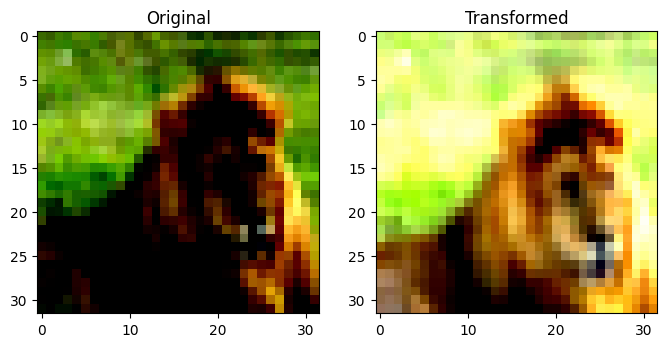

In [ ]:
import torchvision.transforms as T
import torch

### START CODE HERE ### (≈ 12 lines of code)
def Augment(img_size=384):
    hue = T.RandomApply([T.ColorJitter(hue=0.1)], p=0.2)
    other_jitter = T.RandomApply([T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)], p=0.8)
    transform = T.Compose([
        T.ToTensor(),
        T.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
        hue,
        other_jitter,
        T.RandomApply([T.GaussianBlur(kernel_size=(img_size*0.2)//2*2+1, sigma=(0.1, 2.0))],p=0.5),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomGrayscale(p=0.1),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform
### END CODE HERE ###


def test_transform(transform):
    dl_transf = load_cifar100_data(transform=transform, train=False, batch_size=16)
    dl = load_cifar100_data(transform=None, train=False, batch_size=16)
    plt.figure(figsize=(8,8))
    img_id = 15
    plt.subplot(1,2,1)
    imshow(next(iter(dl))[0][img_id,...])
    plt.title('Original')
    plt.subplot(1,2,2)
    imshow(next(iter(dl_transf))[0][img_id,...])
    plt.title('Transformed')

transform = Augment(img_size=32)
test_transform(transform)

# Part IV. Fine-tune the teacher model on CIFAR100

- Fine-tune the teacher model for a maximum of 20 epochs with the proposed augmentations.
- Keep the model with the best performance on CIFAR100 validation split.

[2023] - To train the model with a batch size of on the gcolab resources(~11.2 GB of VRAM with batch size of 48, train time per epoch with Adam ~7 minutes).

[2024] - Fill out the code even if you are not able to train the model for many epochs. A trained model is provided so that you can continue on the next parts of the exercise.

Files already downloaded and verified
Files already downloaded and verified


Ep 1/2: Accuracy : Train:93.61 	 Val:79.43 || Loss: Train 0.198 	 Val 0.846: 100%|██████████| 2/2 [11:59<00:00, 359.54s/it]


Validation accuracy: 79.43%, Validation loss: 0.8463


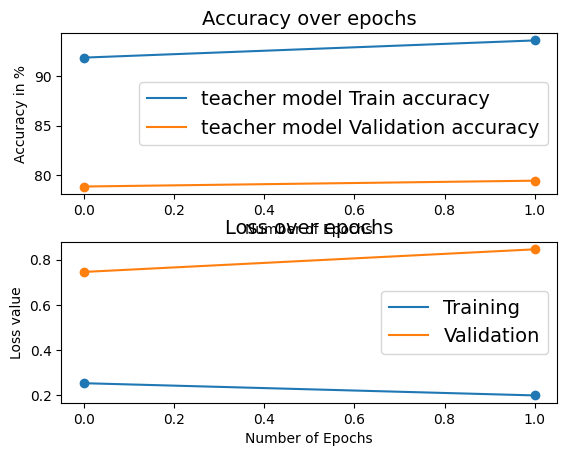

In [10]:
### START CODE HERE ### (≈ 6 lines of code)
teacher_transform_train = Augment(img_size=224)
teacher_transform_val = T.Compose([T.ToTensor(), T.Resize(224)])

train_loader = load_cifar100_data(transform=teacher_transform_val, train=True, batch_size=48)
val_loader = load_cifar100_data(transform=teacher_transform_val, train=False, batch_size=48)
optimizer = torch.optim.Adam(teacher.parameters(), lr=1e-4, weight_decay=1e-6)
teacher_dict_log = finetune(teacher, optimizer, 2, train_loader, val_loader, device)
plot_stats(teacher_dict_log, "teacher model")
### END CODE HERE ###
val_acc , val_loss_epoch = validate(teacher, val_loader, device)
print(f"Validation accuracy: {val_acc:.2f}%, Validation loss: {val_loss_epoch:.4f}")

In [16]:
teacher_checkpoint = torch.load('teacher_cifar100_vitb.pth')
teacher_checkpoint_dict = teacher_checkpoint['model_state_dict']
teacher.load_state_dict(teacher_checkpoint_dict)

<All keys matched successfully>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Expected result
```
Model teacher_cifar100_vitb.pth is loaded from epoch 10 , loss 0.7654579281806946
Files already downloaded and verified

Validation accuracy: 80.18%, Validation loss: 0.7655
```


![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week06/ft_teacher_vit_base.png)



# Part V. Train ViT-tiny (student) from scratch (random init) with cross-entropy (without knowledge distilation)

- Use the implemented augmentation pipeline for training the model from scratch
- 40 epochs should be sufficient to get the expected performance
- Training should take less than 20mins!

`Hint`:

```python
dict_log = finetune(student, optimizer, 40, train_dl, val_dl, device)
```

Files already downloaded and verified
Files already downloaded and verified


Ep 39/40: Accuracy : Train:55.49 	 Val:18.22 || Loss: Train 1.627 	 Val 3.957: 100%|██████████| 40/40 [26:41<00:00, 40.03s/it]


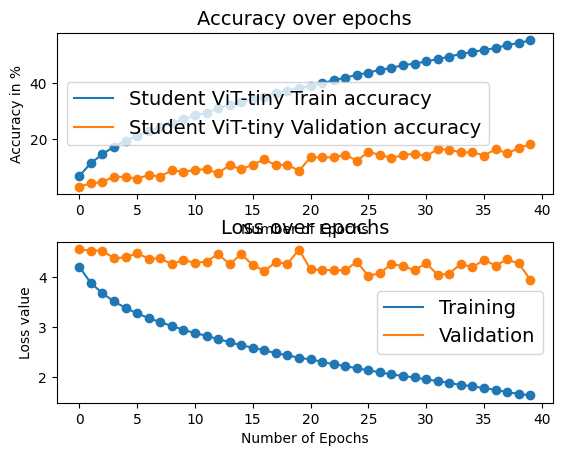

In [20]:
### START CODE HERE ### (≈ 14 lines of code)

train_dl = load_cifar100_data(transform=transform, train=True, batch_size=128)
val_dl = load_cifar100_data(transform=T.ToTensor(), train=False, batch_size=128)

stu_optimizer = torch.optim.Adam(student.parameters(), lr=1e-4, weight_decay=1e-6)
stu_dict_log = finetune(student, stu_optimizer, 40, train_dl, val_dl, device)

plot_stats(stu_dict_log, "Student ViT-tiny")

### END CODE HERE ###
val_acc, val_loss = validate(student, val_dl, device)

### Expected result

```
Model vit-tiny.pth is loaded from epoch 39 , loss 1.6940542459487915
Files already downloaded and verified

ViT Tiny trained from random init on CIFAR100 with augmentations:

Val acc 55.53 Val loss 1.6940542
```


![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week06/scratch_train_vit_tiny_CIFAR100.png)



# Part VI. Implement knowledge distillation loss

$$ Loss = (1- \alpha) CE(p_s,y) + \alpha KL(p_s, p_t) $$

Where y is the labeled target, $p_s,p_t$ are the student/teacher prediction probabilities.

KL is the KL divergence and CE is the cross entropy. Note that KL is not symmetric!

In [21]:
import torch.nn.functional as F
class CriterioDistill():
    ### START CODE HERE ### (≈ 11 lines of code)
    def __init__(self, alpha=0.5):
        self.alpha = alpha

    def __call__(self, logits_teacher, logits_student, labels):
        loss_ce = F.cross_entropy(logits_student, labels)
        loss_kl = F.kl_div(F.log_softmax(logits_student, dim=1),
                           F.softmax(logits_teacher, dim=1), reduction='batchmean')
        return loss_ce * (1 - self.alpha) + loss_kl * self.alpha
    ### END CODE HERE ###

def test_criterio_distill():
    torch.manual_seed(42)
    criterion = CriterioDistill()
    logits_teacher = torch.randn(10, 100)
    logits_student = torch.randn(10, 100)
    labels = torch.randint(0, 100, (10,))
    loss = criterion(logits_teacher, logits_student, labels)
    print(loss)
    assert loss.shape == torch.Size([]), "Wrong shape for loss"

test_criterio_distill()

tensor(3.0656)


### Expected results


```tensor(3.0764)```

# Part VII. Implement MultiScaleData loading

The new dataset class should return the image in the original dimension (32x32), the image rescaled to 224 , and the label.

Why? Because the vit_tiny will accept images of size 32x32, while the teacher vit_base will accept images of 224x224.

In [25]:
class MultiScaleData(torch.utils.data.Dataset):
    def __init__(self, dataset, scale=224, transform=None):
        self.dataset = dataset
        ### START CODE HERE ### (≈ 3 lines of code)
        self.transform = transform
        self.scale = scale
        ### END CODE HERE ###
    def __getitem__(self, index):
        ### START CODE HERE ### (≈ 4 lines of code)
        img, label = self.dataset[index]
        img = self.transform(img)
        img_rescaled = T.Resize(self.scale)(img)
        ### END CODE HERE ###
        return img, img_rescaled, label
    def __len__(self):
        return len(self.dataset)

def load_multiscale_data(transform=None, batch_size=64, num_workers=2, shuffle=False):
    pin = True
    if transform is None:
        transform = get_transform_plain()
    dataset = torchvision.datasets.CIFAR100(root='../data',  transform=None, train=True, download=True)
    dataset_rescaled = MultiScaleData(dataset, scale=224, transform=transform)
    loader = torch.utils.data.DataLoader(dataset_rescaled,
                                         batch_size=batch_size,
                                         shuffle=shuffle,
                                         num_workers=num_workers,
                                         pin_memory=pin)
    return loader

def test_MultiScaleData():
    transform = get_transform_plain()
    loader = load_multiscale_data(transform=transform, batch_size=4, num_workers=2, shuffle=False)
    imgs, imgs_rescaled, labels = next(iter(loader))
    assert imgs.shape == (4, 3, 32, 32), "Wrong shape for img"
    assert imgs_rescaled.shape == (4, 3, 224, 224), "Wrong shape for img_rescaled"
    print("Success!")

test_MultiScaleData()

Files already downloaded and verified
Success!


# Part VIII. Adjust training code to support knowledge distillation from the teacher model


In [36]:
def train_one_epoch_distill(model, optimizer, train_loader, device, teacher, alpha=0.5):
    model.train()
    teacher.eval()
    criterion_distill = CriterioDistill(alpha)
    loss_step = []
    correct, total = 0, 0
    for data in train_loader:
        ### START CODE HERE ### (≈ 14 line of code)
        imgs, imgs_rescaled, labels = data
        imgs, imgs_rescaled, labels= imgs.to(device), imgs_rescaled.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion_distill(teacher(imgs_rescaled), outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            loss_step.append(loss.item())
        ### END CODE HERE ###
    loss_curr_epoch = np.mean(loss_step)
    train_acc = (100 * correct / total).cpu()
    return loss_curr_epoch, train_acc

# GIVEN.
def train_distill(model, teacher, optimizer, num_epochs, train_loader, val_loader, device, prefix='model', alpha=0.5):
    best_val_loss = 1e8
    best_val_acc = 0
    model, teacher = model.to(device), teacher.to(device)
    dict_log = {"train_acc_epoch":[], "val_acc_epoch":[], "loss_epoch":[], "val_loss":[]}
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        loss_curr_epoch, train_acc = train_one_epoch_distill(model, optimizer, train_loader, device, teacher, alpha)
        val_acc, val_loss = validate(model, val_loader, device)

        # Print epoch results to screen
        msg = (f'Ep {epoch}/{num_epochs}: Accuracy : Train:{train_acc:.2f} \t Val:{val_acc:.2f} || Loss: Train {loss_curr_epoch:.3f} \t Val {val_loss:.3f}')
        pbar.set_description(msg)
        # Track stats
        dict_log["train_acc_epoch"].append(train_acc)
        dict_log["val_acc_epoch"].append(val_acc)
        dict_log["loss_epoch"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  }, f'{prefix}_best_model_min_val_loss.pth')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  }, f'{prefix}_best_model_max_val_acc.pth')
    return dict_log

# Part IX. Train student with knowledge distillation


- Plug everything together and show the training curves, even if you train for a small number of epochs.
- Print the validation accuracy of the best model.

Files already downloaded and verified
Files already downloaded and verified


Ep 39/40: Accuracy : Train:61.14 	 Val:18.68 || Loss: Train 1.281 	 Val 4.015: 100%|██████████| 40/40 [3:39:59<00:00, 329.99s/it]


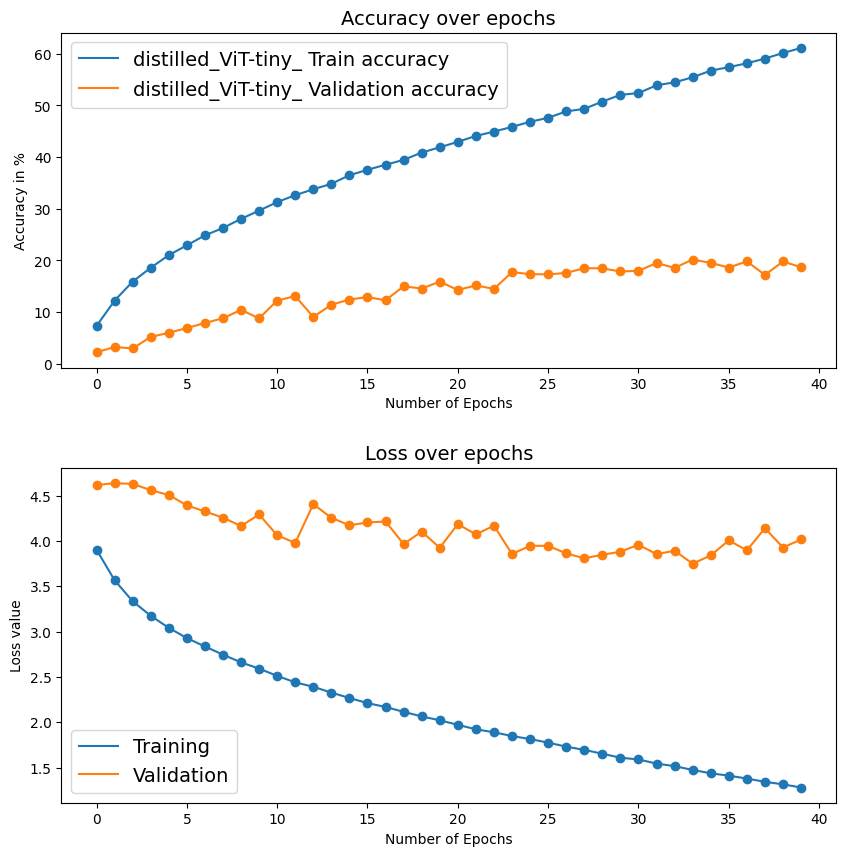

In [37]:
### START CODE HERE ### (≈ 16 lines of code)
# load teacher
teacher = timm.create_model("vit_base_patch16_224", num_classes=100, pretrained=True)
checkpoint = torch.load("./teacher_cifar100_vitb.pth", map_location=device)
checkpoint_dict = checkpoint['model_state_dict']
teacher.load_state_dict(checkpoint_dict)

# load student
model_args = dict(
    img_size = 32,
    patch_size=8,
    embed_dim=192,
    num_heads=3,
    depth=12,
    num_classes=100,
    norm_layer=nn.LayerNorm,
    # pre_norm = True,
)
student = timm.models.VisionTransformer(**model_args)

# optimizer
optimizer = optim.Adam(student.parameters(), lr=1e-4)

# transform and loaders
transform = Augment(img_size=32)
train_dl = load_multiscale_data(transform=transform)
val_dl = load_cifar100_data(transform=T.ToTensor(), train=False)

# hyperparameters
num_epochs = 40
alpha = 0.5
### END CODE HERE ###

# Launch training!
dict_log = train_distill(student, teacher, optimizer, num_epochs, train_dl, val_dl, device, prefix='distill_vit_t_kl_ts', alpha=alpha)
plt.figure(figsize=(10,10))
plot_stats(dict_log, modelname="distilled_ViT-tiny_", title="distilled_ViT-tiny_")
plt.savefig("ViT-tiny_CIFAR100_DISTILL___.png")

### Expected results
You can train the model even for 40 epochs (~120 min) and get a validarion accuracy of ~60%, already significantly better than training the vit-tiny from scratch on cifar100 without distillation.

Here is our results for reference and in case you were curious to see what's the outcome of training for more epochs. Of course, we don't expect you to reproduce our results with the gcolab resources but here is what we got (for alpha=0.7 - maybe not be the optimal choice):

Our result for reference:
```
Validation accuracy: 61.51 	 Validation loss: 1.511
```
Remember that ViT Tiny trained from random init on CIFAR100 with augmentations: `Val acc 55.76 || Val loss 1.71`



![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week06/distilled_vit_tiny.png)



# Conclusion and Bonus reads

That's the end of this exercise. If you reached this point, **congratulations**!


Can you find a better alpha? How can alpha be interpreted?

What additional losses did the the paper "Be Your Own Teacher: Improve the Performance of Convolutional Neural Networks via Self Distillation" intoduce?

